In [1]:
from pathlib import Path
from datetime import datetime
import io

import gdown
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.stats import gaussian_kde


dataset_path = Path('dataset')
dataset_path.mkdir(exist_ok=True)

dataset_id = "1zFpeQewhh-otoCSMo0OoTc5yGzQlCxRv?"
salida_raw = Path(dataset_path,"data_raw.cvs")


In [2]:
for archivo in dataset_path.iterdir():
        if archivo.is_file():
            print(f"Eliminando archivo: {archivo}")
            archivo.unlink()

paths = gdown.download_folder(
        id=dataset_id,
        output=str(dataset_path),
        quiet=True,
        use_cookies=True,
        remaining_ok=True
        )

In [3]:
archivos = sorted(dataset_path.glob("*.csv"))

if len(archivos) == 1:
            archivo_unico = archivos[0]
            print(f"Solo se encontró un archivo: {archivo_unico}")
            print(f"Renombrando a: {salida_raw}")
            archivo_unico.rename(salida_raw)
            print("Archivo renombrado correctamente.")
else:
  print("Unificando archivos CSV...")
  df_final = pd.read_csv(archivos[0])
  print(f"Primer archivo leído: {archivos[0]}")
  for f in archivos[1:]:
    print(f"Concatenando archivo: {f}")
    df = pd.read_csv(f)
    df_final = pd.concat([df_final, df], ignore_index=True)

    df_final.to_csv(salida_raw, index=False)
    print(f"Archivo combinado guardado en: {salida_raw}")

Unificando archivos CSV...
Primer archivo leído: dataset/dataset_boletin_2014_2025.csv
Concatenando archivo: dataset/dataset_boletin_2026.csv
Archivo combinado guardado en: dataset/data_raw.cvs


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Anio                     96 non-null     int64 
 1   Semana                   96 non-null     int64 
 2   Entidad                  96 non-null     object
 3   Padecimiento             96 non-null     object
 4   Casos_semana             96 non-null     int64 
 5   Acumulado_hombres        96 non-null     int64 
 6   Acumulado_mujeres        96 non-null     int64 
 7   Acumulado_anio_anterior  96 non-null     int64 
dtypes: int64(6), object(2)
memory usage: 6.1+ KB


In [5]:
df = pd.read_csv(salida_raw)
fecha_actual = datetime.now().strftime("%Y-%m-%d %H:%M")
filas = f"{len(df):,}"
columnas = f"{df.shape[1]:,}"
porcentaje_nulos = f"{df.isna().mean().mean() * 100:.2f}%"
columnas_numericas = df.select_dtypes(include='number').shape[1]
columnas_categoricas = df.select_dtypes(include=['object', 'category']).shape[1]
otros_columnas = df.shape[1] - (columnas_numericas + columnas_categoricas)

resumen = [
    ["Fecha", fecha_actual],
    ["Filas", filas],
    ["Columnas", columnas],
    ["Columnas numéricas", f"{columnas_numericas}"],
    ["Columnas categóricas", f"{columnas_categoricas}"],
    ["Otras columnas", f"{otros_columnas}"],
    ["Porcentaje nulos", porcentaje_nulos]
]

buffer = io.StringIO()
df.info(buf=buffer)
info_str = buffer.getvalue()
lineas = info_str.splitlines()
lineas_columnas = [l.strip() for l in lineas if l.strip().startswith(tuple(str(i) for i in range(len(df.columns))))]
tabla = [l.split(maxsplit=3) for l in lineas_columnas]

df_unicos = df.nunique(dropna=True).to_frame("Valores únicos") \
                .assign(Tipo=df.dtypes.astype(str)) \
                .query("`Valores únicos` > 0") \
                .sort_values("Valores únicos", ascending=False)

df_nulos = df.isna().sum().to_frame("Nulos") \
                .assign(Tipo=df.dtypes.astype(str)) \
                .query("Nulos > 0") \
                .sort_values("Nulos", ascending=False)

print("Info")
print(tabulate(tabla, headers=["#", "Column", "Non-Null Count", "Dtype"], tablefmt="grid"))
print("\nResumen")
print(tabulate(resumen, headers=["Resumen del DataFrame", "Valor"], tablefmt="grid"))
print("\nValores únicos")
print(tabulate(df_unicos, headers=["Columna", "Valores únicos", "Tipo"], tablefmt="grid"))
print("\nValores nulos")
print(tabulate(df_nulos, headers=["Columna", "Nulos", "Tipo"], tablefmt="grid"))


Info
+-----+-------------------------+------------------+-------------------+
|   # | Column                  |   Non-Null Count | Dtype             |
+=====+=========================+==================+===================+
|   0 | Anio                    |            59712 | non-null  int64   |
+-----+-------------------------+------------------+-------------------+
|   1 | Semana                  |            59712 | non-null  int64   |
+-----+-------------------------+------------------+-------------------+
|   2 | Entidad                 |            59712 | non-null  object  |
+-----+-------------------------+------------------+-------------------+
|   3 | Padecimiento            |            59712 | non-null  object  |
+-----+-------------------------+------------------+-------------------+
|   4 | Casos_semana            |            59709 | non-null  float64 |
+-----+-------------------------+------------------+-------------------+
|   5 | Acumulado_hombres       |            5

In [6]:
print("Generando estadísticas de columnas numéricas...")
num = df.select_dtypes(include='number')
resumen = num.describe().T.round(2)
print(tabulate(resumen, headers="keys", tablefmt="grid", floatfmt=".2f"))

print("\nGenerando estadísticas de columnas categóricas...")
cat = df.select_dtypes(include=['object', 'category'])
resumen = [
    {
        "columna": col,
        "conteo": serie.size,
        "valores_únicos": serie.nunique(),
        "moda": serie.mode().iloc[0] if not serie.mode().empty else "N/A",
        "freq_moda": serie.value_counts().iloc[0],
        "%_moda": round(serie.value_counts().iloc[0] / serie.size * 100, 2)
    }
    for col, serie in cat.items() if not serie.empty
]

print(tabulate(resumen, headers="keys", tablefmt="grid", floatfmt=".2f"))




Generando estadísticas de columnas numéricas...
+-------------------------+----------+---------+---------+---------+---------+---------+---------+----------+
|                         |    count |    mean |     std |     min |     25% |     50% |     75% |      max |
+=========================+==========+=========+=========+=========+=========+=========+=========+==========+
| Anio                    | 59712.00 | 2019.48 |    3.44 | 2014.00 | 2016.00 | 2019.00 | 2022.00 |  2026.00 |
+-------------------------+----------+---------+---------+---------+---------+---------+---------+----------+
| Semana                  | 59712.00 |   26.43 |   14.98 |    1.00 |   13.00 |   26.00 |   39.00 |    53.00 |
+-------------------------+----------+---------+---------+---------+---------+---------+---------+----------+
| Casos_semana            | 59709.00 |   24.91 |   52.78 |    0.00 |    1.00 |    4.00 |   26.00 |  1311.00 |
+-------------------------+----------+---------+---------+---------+----

In [7]:
cat = df.select_dtypes(include=['object', 'category'])

# Iterar sobre cada columna y mostrar frecuencias
for col in cat.columns:
    # Contar valores (incluyendo NAs como "N/A")
    vc = cat[col].fillna("N/A").value_counts(dropna=False)

    # Convertir a DataFrame para tabulate
    tabla = vc.reset_index()
    tabla.columns = ["Valor", "Frecuencia"]

    print(f"\nColumna: {col}")
    print(tabulate(tabla, headers="keys", tablefmt="grid"))



Columna: Entidad
+----+---------------------+--------------+
|    | Valor               |   Frecuencia |
+====+=====================+==============+
|  0 | Aguascalientes      |         1866 |
+----+---------------------+--------------+
|  1 | Baja California     |         1866 |
+----+---------------------+--------------+
|  2 | Baja California Sur |         1866 |
+----+---------------------+--------------+
|  3 | Campeche            |         1866 |
+----+---------------------+--------------+
|  4 | Coahuila            |         1866 |
+----+---------------------+--------------+
|  5 | Colima              |         1866 |
+----+---------------------+--------------+
|  6 | Chiapas             |         1866 |
+----+---------------------+--------------+
|  7 | Chihuahua           |         1866 |
+----+---------------------+--------------+
|  8 | Durango             |         1866 |
+----+---------------------+--------------+
|  9 | Jalisco             |         1866 |
+----+--------

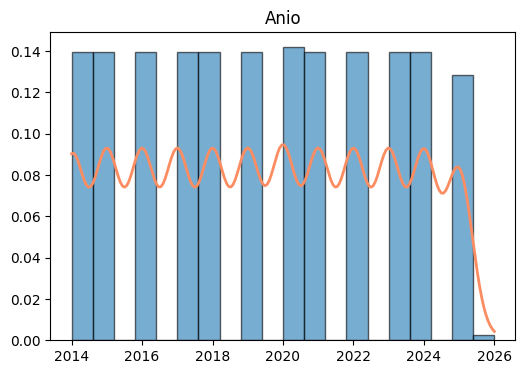

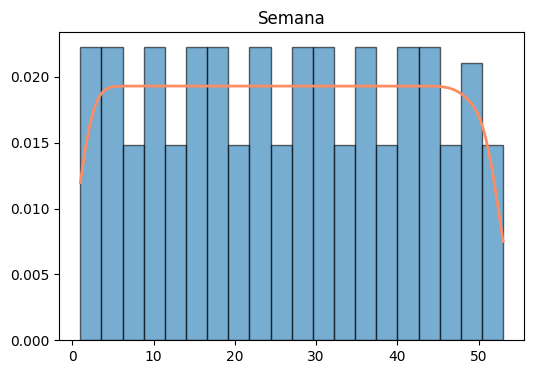

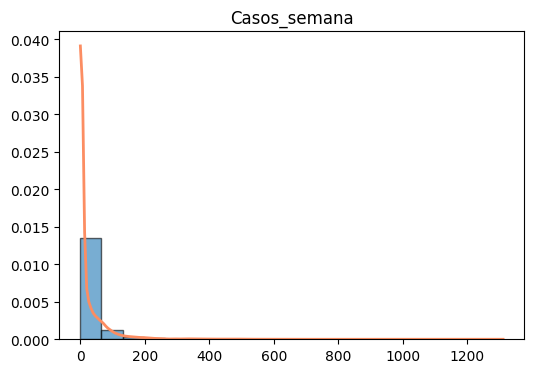

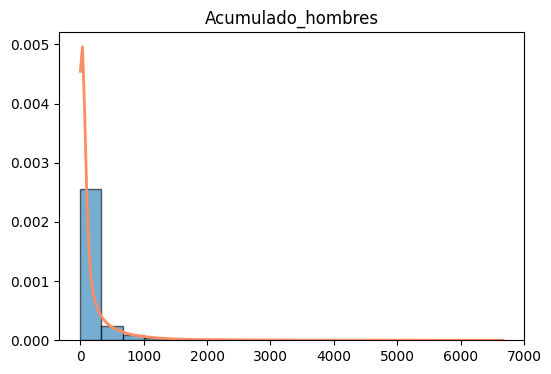

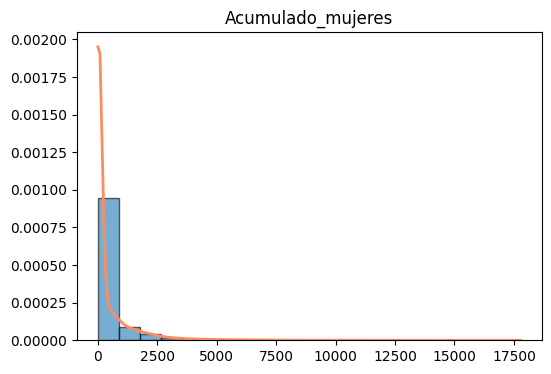

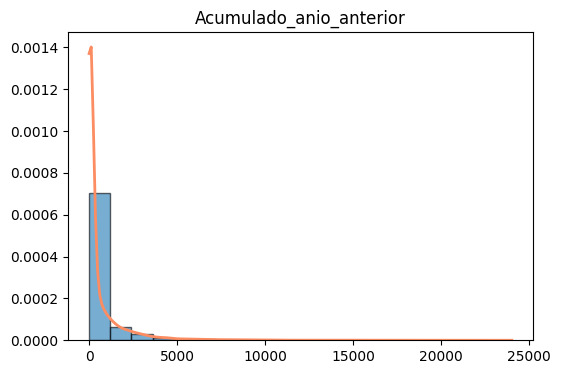

In [8]:
num = df.select_dtypes(include=['number'])
palette = sns.color_palette("Set2")

for col in num.columns:

    plt.figure(figsize=(6,4))
    plt.hist(num[col], bins=20, edgecolor='black', alpha=0.6, density=True)
    plt.title(f"{col}")
    kde = gaussian_kde(num[col].dropna())
    x_vals = np.linspace(num[col].min(), num[col].max(), 200)

    plt.plot(x_vals, kde(x_vals), color=palette[1], linewidth=2)
    plt.ylabel(None)

    plt.show()



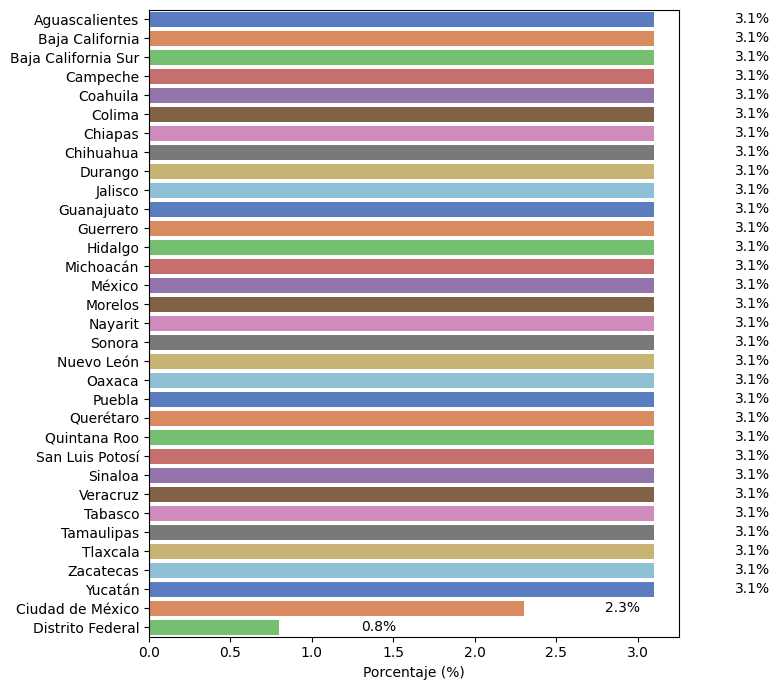

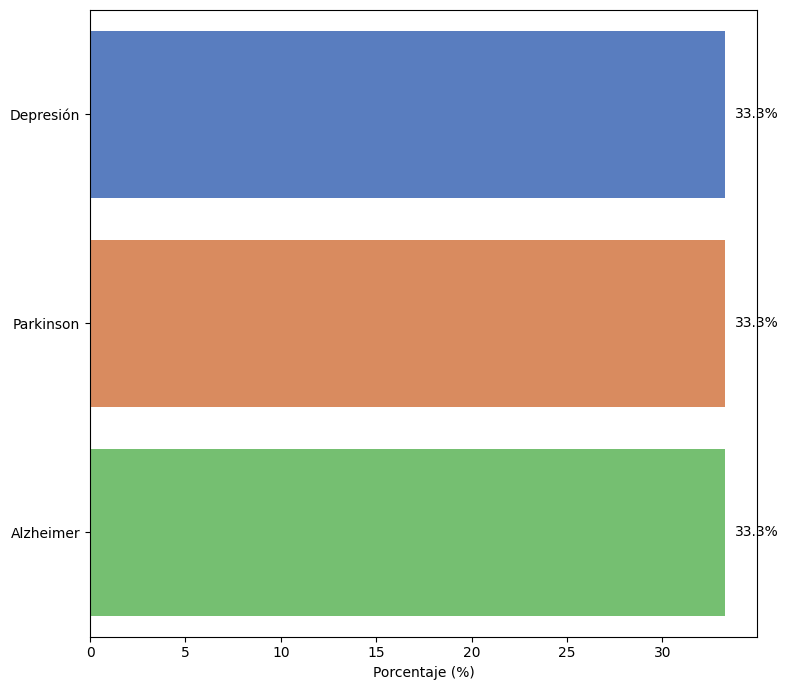

In [9]:
cat = df.select_dtypes(include=['object', 'category'])

for col in cat.columns:
    serie = cat[col].dropna()
    if serie.empty:
        continue

    # Calcular porcentajes
    porcentajes = (serie.value_counts(normalize=True) * 100).round(1)

    #plt.figure(figsize=(10, len(porcentajes) * 0.5))
    plt.figure(figsize=(8, 7))

    ax = sns.barplot(
        x=porcentajes.values,
        y=porcentajes.index,
        hue=porcentajes.index,
        dodge=False,
        palette="muted",
        legend=False
    )

    #ax.set_title(f"Distribución porcentual de {col}")
    ax.set_title(None)
    ax.set_xlabel("Porcentaje (%)")
    ax.set_ylabel("")

    # Etiquetas de porcentaje al lado de cada barra
    for i, v in enumerate(porcentajes.values):
        ax.text(v + 0.5, i, f"{v}%", va="center")

    plt.tight_layout()
    plt.show()

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0.5, 0, 'Anio'),
  Text(1.5, 0, 'Semana'),
  Text(2.5, 0, 'Casos_semana'),
  Text(3.5, 0, 'Acumulado_hombres'),
  Text(4.5, 0, 'Acumulado_mujeres'),
  Text(5.5, 0, 'Acumulado_anio_anterior')])

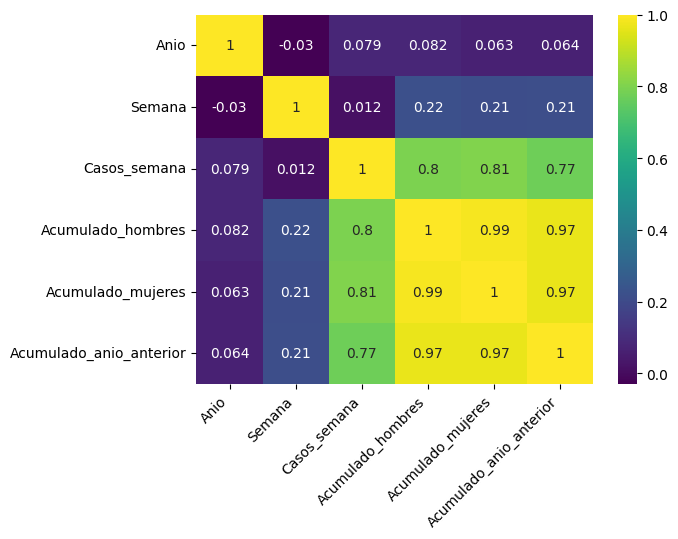

In [10]:
num = df.select_dtypes(include='number').dropna(axis=1, how="all")
sns.heatmap(num.corr(numeric_only=True), cmap="viridis", annot=True)
plt.xticks(rotation=45, ha="right")
#plt.title("Matriz de correlación")

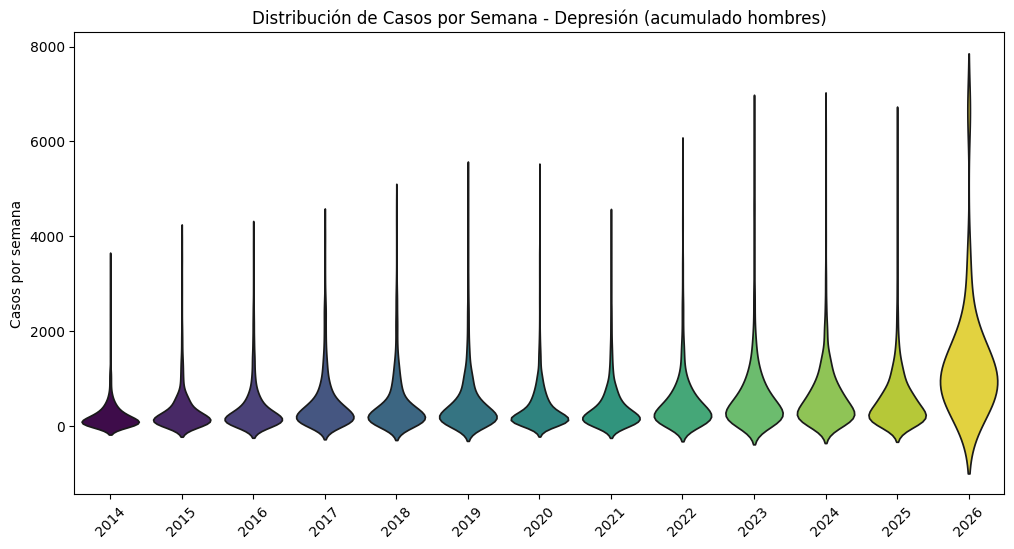

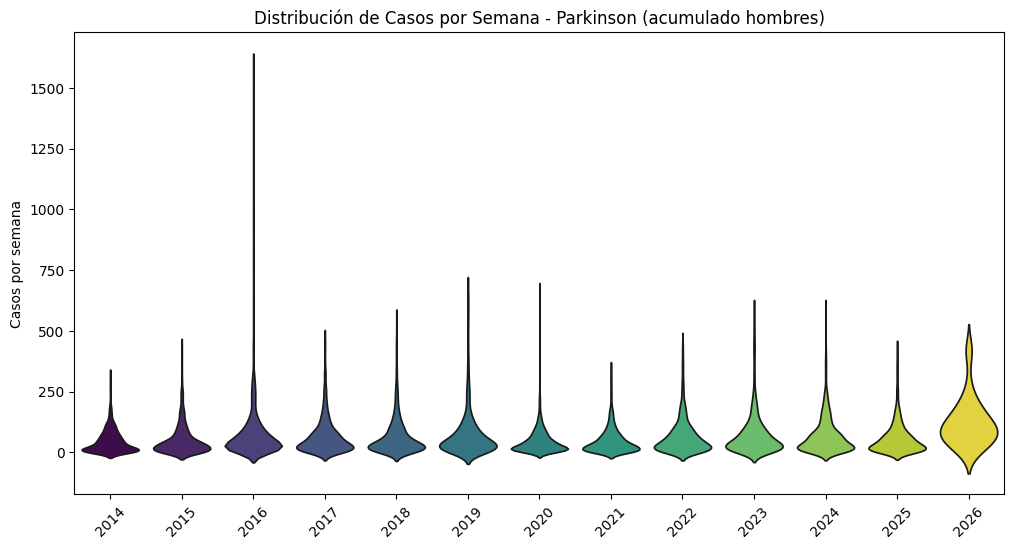

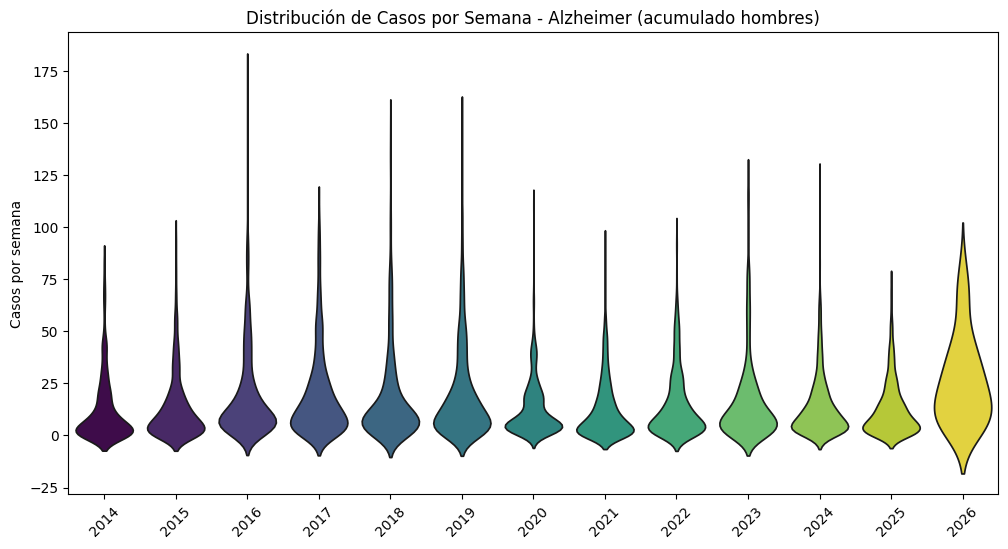

In [16]:
padecimientos = df["Padecimiento"].unique()

for padecimiento in padecimientos:
    plt.figure(figsize=(12,6))

    sns.violinplot(
        x="Anio",
        y="Acumulado_hombres",
        hue="Anio",
        data=df[df["Padecimiento"] == padecimiento],
        palette="viridis",
        inner=None
    )

    plt.title(f"Distribución de Casos por Semana - {padecimiento} (acumulado hombres)")
    plt.xlabel(None)
    plt.ylabel("Casos por semana")
    plt.xticks(rotation=45)
    plt.legend().remove()

    plt.show()

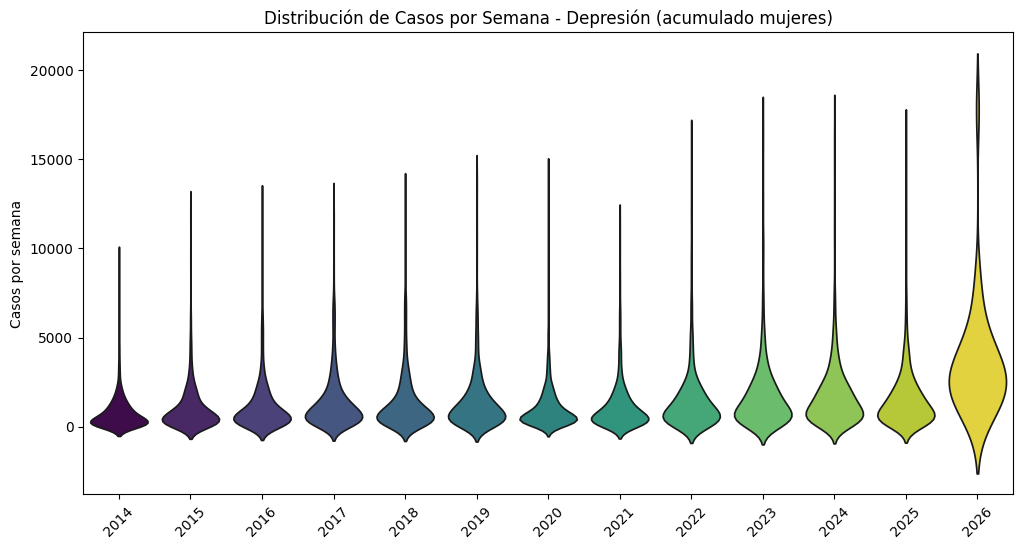

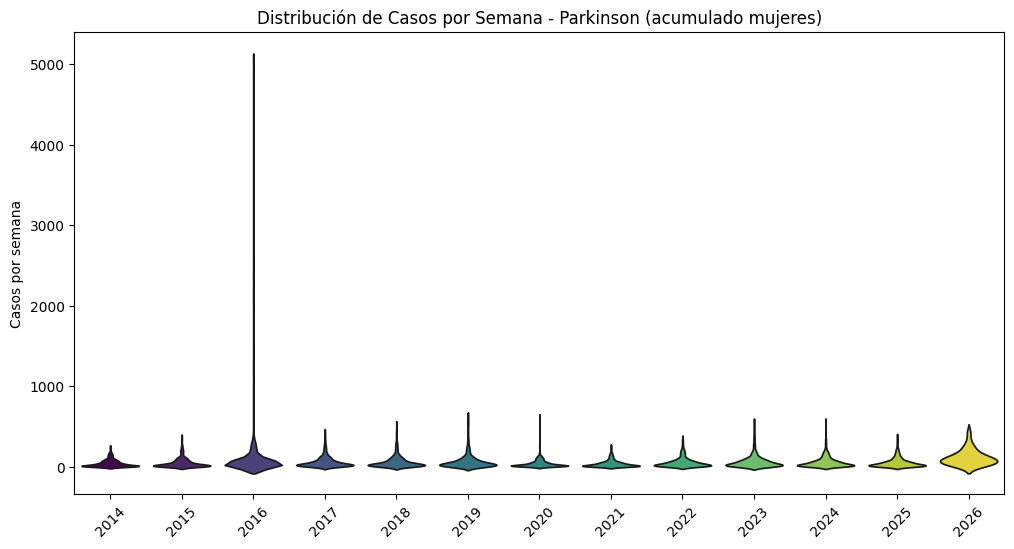

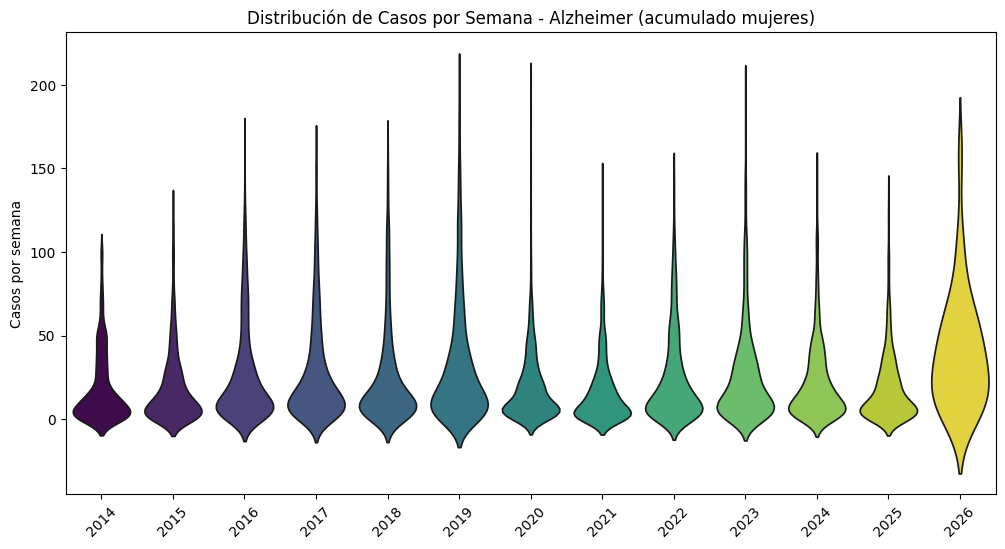

In [17]:
padecimientos = df["Padecimiento"].unique()

for padecimiento in padecimientos:
    plt.figure(figsize=(12,6))

    sns.violinplot(
        x="Anio",
        y="Acumulado_mujeres",
        hue="Anio",
        data=df[df["Padecimiento"] == padecimiento],
        palette="viridis",
        inner=None
    )

    plt.title(f"Distribución de Casos por Semana - {padecimiento} (acumulado mujeres)")
    plt.xlabel(None)
    plt.ylabel("Casos por semana")
    plt.xticks(rotation=45)
    plt.legend().remove()

    plt.show()